## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [5]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [11]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75, 0.9]
redice_lr_patient = [5, 10, 15]

In [12]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 4s 77us/step - loss: 1.2676 - acc: 0.5600 - val_loss: 1.4972 - val_acc: 0.4754
Epoch 14/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.2469 - acc: 0.5688 - val_loss: 1.4951 - val_acc: 0.4751
Epoch 15/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2275 - acc: 0.5762 - val_loss: 1.4777 - val_acc: 0.4802
Epoch 16/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.2061 - acc: 0.5840 - val_loss: 1.4755 - val_acc: 0.4783
Epoch 17/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.1877 - acc: 0.5915 - val_loss: 1.4752 - val_acc: 0.4888
Epoch 18/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.1682 - acc: 0.5973 - val_loss: 1.4587 - val_acc: 0.4868
Epoch 19/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1486 - acc: 0.6056 - val_loss: 1.4660 - val_acc: 0.4872
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 6s 115us/step - loss: 2.2357 - acc: 0.2591 - val_loss: 2.0822 - val_acc: 0.3116
Epoch 2/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.7702 - acc: 0.3847 - val_loss: 1.8342 - val_acc: 0.3704
Epoch 3/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.6395 - acc: 0.4255 - val_loss: 1.7323 - val_acc: 0.4062
Epoch 4/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5673 - acc: 0.4491 - val_loss: 1.6493 - val_acc: 0.4245
Epoch 5/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5105 - acc: 0.4714 - val_loss: 1.6112 - val_acc: 0.4334
Epoch 6/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.4679 - acc: 0.4842 - val_loss: 1.5853 - val_acc: 0.4449
Epoch 7/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.4280 - acc: 0.5006 - val_loss: 1.5756 - val_acc: 0.4527
Epoch 8/25
50000/50000 [===========================

50000/50000 [==============================] - 4s 74us/step - loss: 1.0428 - acc: 0.6444 - val_loss: 1.4608 - val_acc: 0.4872
Epoch 25/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.0259 - acc: 0.6509 - val_loss: 1.4517 - val_acc: 0.4923
Numbers of exp: 5, reduce_factor: 0.75, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.2919 - acc: 0.5507 - val_loss: 1.4821 - val_acc: 0.4772
Epoch 13/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.2701 - acc: 0.5578 - val_loss: 1.4838 - val_acc: 0.4821
Epoch 14/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.2485 - acc: 0.5660 - val_loss: 1.4799 - val_acc: 0.4825
Epoch 15/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.2276 - acc: 0.5731 - val_loss: 1.4718 - val_acc: 0.4861
Epoch 16/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.2082 - acc: 0.5800 - val_loss: 1.4699 - val_acc: 0.4871
Epoch 17/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1894 - acc: 0.5872 - val_loss: 1.4576 - val_acc: 0.4898
Epoch 18/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.1713 - acc: 0.5941 - val_loss: 1.4583 - val_acc: 0.4914
Epoch 19/25
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 136us/step - loss: 2.2448 - acc: 0.2644 - val_loss: 2.1873 - val_acc: 0.3139
Epoch 2/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.7628 - acc: 0.3843 - val_loss: 1.8812 - val_acc: 0.3688
Epoch 3/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.6395 - acc: 0.4256 - val_loss: 1.7499 - val_acc: 0.3992
Epoch 4/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5686 - acc: 0.4491 - val_loss: 1.6732 - val_acc: 0.4215
Epoch 5/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5144 - acc: 0.4690 - val_loss: 1.6050 - val_acc: 0.4366
Epoch 6/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.4706 - acc: 0.4861 - val_loss: 1.5879 - val_acc: 0.4436
Epoch 7/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.4322 - acc: 0.4988 - val_loss: 1.5701 - val_ac

50000/50000 [==============================] - 4s 76us/step - loss: 0.5028 - acc: 0.8493 - val_loss: 1.5121 - val_acc: 0.5126
Epoch 23/25
50000/50000 [==============================] - 4s 77us/step - loss: 0.4846 - acc: 0.8586 - val_loss: 1.5187 - val_acc: 0.5220
Epoch 24/25
50000/50000 [==============================] - 4s 77us/step - loss: 0.4717 - acc: 0.8647 - val_loss: 1.5349 - val_acc: 0.5218
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.4596 - acc: 0.8669 - val_loss: 1.5685 - val_acc: 0.5079
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batc

50000/50000 [==============================] - 4s 76us/step - loss: 1.1969 - acc: 0.5865 - val_loss: 1.5096 - val_acc: 0.4689
Epoch 10/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1693 - acc: 0.5964 - val_loss: 1.4463 - val_acc: 0.4906
Epoch 11/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1434 - acc: 0.6072 - val_loss: 1.4559 - val_acc: 0.4931
Epoch 12/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1184 - acc: 0.6181 - val_loss: 1.4411 - val_acc: 0.4946
Epoch 13/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.0946 - acc: 0.6270 - val_loss: 1.4237 - val_acc: 0.4995
Epoch 14/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.0708 - acc: 0.6357 - val_loss: 1.4106 - val_acc: 0.5070
Epoch 15/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.0508 - acc: 0.6419 - val_loss: 1.4183 - val_acc: 0.5081
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.9451 - acc: 0.3395 - val_loss: 1.9465 - val_acc: 0.3431
Epoch 2/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.5864 - acc: 0.4432 - val_loss: 1.7309 - val_acc: 0.3939
Epoch 3/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.4912 - acc: 0.4780 - val_loss: 1.6526 - val_acc: 0.4213
Epoch 4/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4265 - acc: 0.4997 - val_loss: 1.5640 - val_acc: 0.4520
Epoch 5/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.3768 - acc: 0.5175 - val_loss: 1.5320 - val_acc: 0.4629
Epoch 6/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3366 - acc: 0.5330 - val_loss: 1.5276 - val_acc: 0.4646
Epoch 7/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3000 - acc: 0.5475 - val_loss: 1.4875 - val_ac

50000/50000 [==============================] - 4s 89us/step - loss: 0.9487 - acc: 0.6848 - val_loss: 1.4177 - val_acc: 0.5084
Epoch 25/25
50000/50000 [==============================] - 4s 76us/step - loss: 0.9327 - acc: 0.6905 - val_loss: 1.4184 - val_acc: 0.5045
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 5s 94us/step - loss: 1.2544 - acc: 0.5660 - val_loss: 1.4608 - val_acc: 0.4867
Epoch 11/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.2337 - acc: 0.5737 - val_loss: 1.4581 - val_acc: 0.4838
Epoch 12/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.2140 - acc: 0.5816 - val_loss: 1.4682 - val_acc: 0.4870
Epoch 13/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.1953 - acc: 0.5890 - val_loss: 1.4566 - val_acc: 0.4924
Epoch 14/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1781 - acc: 0.5960 - val_loss: 1.4432 - val_acc: 0.4943
Epoch 15/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1622 - acc: 0.6012 - val_loss: 1.4496 - val_acc: 0.4918
Epoch 16/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1449 - acc: 0.6084 - val_loss: 1.4728 - val_acc: 0.4820
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.8436 - acc: 0.3637 - val_loss: 2.8726 - val_acc: 0.2207
Epoch 2/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5329 - acc: 0.4563 - val_loss: 2.6503 - val_acc: 0.2519
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4275 - acc: 0.4947 - val_loss: 2.1030 - val_acc: 0.3228
Epoch 4/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3451 - acc: 0.5237 - val_loss: 2.2306 - val_acc: 0.3026
Epoch 5/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2743 - acc: 0.5498 - val_loss: 1.8708 - val_acc: 0.3699
Epoch 6/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2209 - acc: 0.5707 - val_loss: 1.9830 - val_acc: 0.3515
Epoch 7/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1706 - acc: 0.5871 - val_loss: 1.8440 - val_ac

50000/50000 [==============================] - 5s 106us/step - loss: 0.6814 - acc: 0.7835 - val_loss: 1.5034 - val_acc: 0.5023
Epoch 23/25
50000/50000 [==============================] - 4s 90us/step - loss: 0.6613 - acc: 0.7909 - val_loss: 1.5381 - val_acc: 0.5009
Epoch 24/25
50000/50000 [==============================] - 3s 70us/step - loss: 0.6460 - acc: 0.7992 - val_loss: 1.6233 - val_acc: 0.4783
Epoch 25/25
50000/50000 [==============================] - 4s 76us/step - loss: 0.6304 - acc: 0.8016 - val_loss: 1.5166 - val_acc: 0.5015
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
bat

Epoch 10/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.1758 - acc: 0.5908 - val_loss: 1.6005 - val_acc: 0.4527
Epoch 11/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1447 - acc: 0.6041 - val_loss: 1.5645 - val_acc: 0.4518
Epoch 12/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.1152 - acc: 0.6151 - val_loss: 1.5404 - val_acc: 0.4604
Epoch 13/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.0862 - acc: 0.6271 - val_loss: 1.6161 - val_acc: 0.4511
Epoch 14/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.0549 - acc: 0.6368 - val_loss: 1.4732 - val_acc: 0.4778
Epoch 15/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.0314 - acc: 0.6453 - val_loss: 1.5214 - val_acc: 0.4657
Epoch 16/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.0054 - acc: 0.6572 - val_loss: 1.5107 - val_acc: 0.4769
Epoch 17/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 101us/step - loss: 2.0569 - acc: 0.3102 - val_loss: 2.0544 - val_acc: 0.3167: 1s - loss: 2.1538 - ac
Epoch 2/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.7070 - acc: 0.4052 - val_loss: 1.8266 - val_acc: 0.3755
Epoch 3/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.5866 - acc: 0.4435 - val_loss: 1.7168 - val_acc: 0.4009
Epoch 4/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.5041 - acc: 0.4730 - val_loss: 1.7089 - val_acc: 0.4018
Epoch 5/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4431 - acc: 0.4942 - val_loss: 1.6204 - val_acc: 0.4336
Epoch 6/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.3913 - acc: 0.5112 - val_loss: 1.6611 - val_acc: 0.4301
Epoch 7/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.3485 - acc: 0.5296 - v

50000/50000 [==============================] - 2s 47us/step - loss: 0.9298 - acc: 0.6885 - val_loss: 1.5766 - val_acc: 0.4590
Epoch 24/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.9142 - acc: 0.6961 - val_loss: 1.4911 - val_acc: 0.4849
Epoch 25/25
50000/50000 [==============================] - 2s 45us/step - loss: 0.8943 - acc: 0.7039 - val_loss: 1.5615 - val_acc: 0.4819
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_lay

50000/50000 [==============================] - 2s 40us/step - loss: 1.2749 - acc: 0.5555 - val_loss: 1.5509 - val_acc: 0.4501
Epoch 11/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.2467 - acc: 0.5661 - val_loss: 1.4952 - val_acc: 0.4748
Epoch 12/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.2189 - acc: 0.5777 - val_loss: 1.4970 - val_acc: 0.4702
Epoch 13/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1929 - acc: 0.5878 - val_loss: 1.5143 - val_acc: 0.4743
Epoch 14/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.1700 - acc: 0.5960 - val_loss: 1.4923 - val_acc: 0.4753
Epoch 15/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.1457 - acc: 0.6058 - val_loss: 1.4808 - val_acc: 0.4796
Epoch 16/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.1218 - acc: 0.6143 - val_loss: 1.4902 - val_acc: 0.4786
Epoch 17/25
50000/50000 [=====================

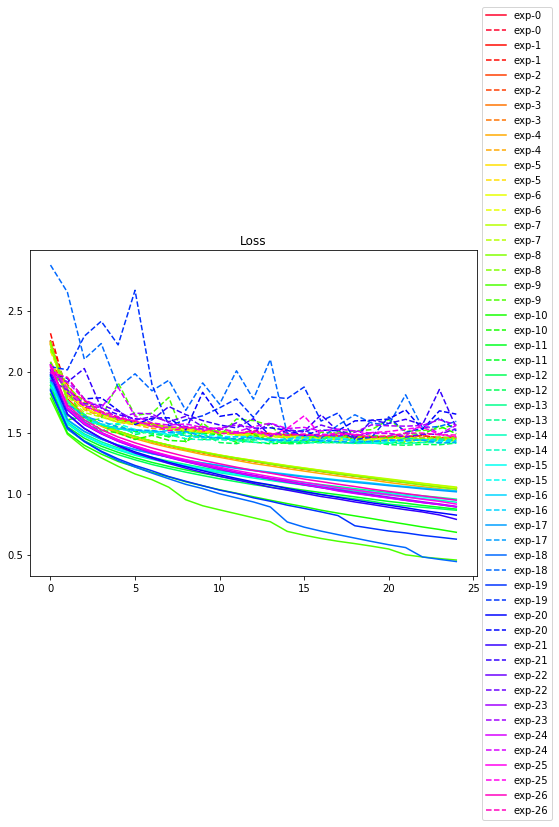

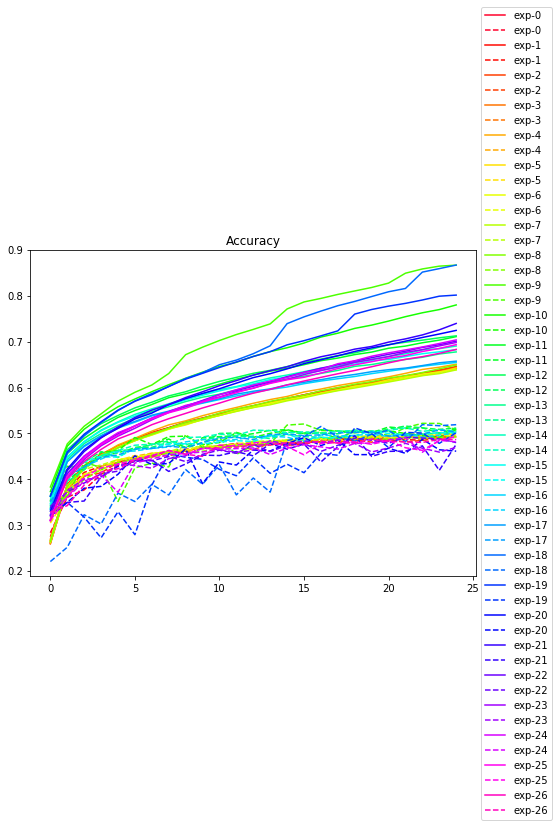

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()